In [230]:
!pip3 install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [231]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
import torchvision
import torch

from torchvision.utils import make_grid
from torchmetrics import JaccardIndex

from tqdm import tqdm
import time

In [232]:
# If running on google colab, run the following code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# U-Net

In this notebook, we implemented an U-Net to do the segmentation on HAM10000 Datase

In [233]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available() # Use gpu

True

## Datasets

 - Creating a custom image dataset 
 - To apply image argumentation to each image

In [234]:
class SkinCancerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transformation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transformation
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_segmentation.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Data argumentations
- Regularization on training data to avoid overfitting

In [235]:
# Create a sequential of transformation for training
transform = A.Compose(
        [
            A.Resize(height=90, width=90),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

# testing_transform = transforms.Compose([
#     # # Random Crop, the return size is 255 * 255
#     transforms.Resize(size=(255,255)),
#     transforms.ToTensor()
# ])

### Load the datasets
- Training
- Validation: 102 images
- Testing

In [236]:
# Apply the transformation to datasets
training = SkinCancerDataset("drive/My Drive/skin_dataset/train", "drive/My Drive/skin_dataset/mask", transformation=transform)

### Create Dataloaders
- batch_size = 32

In [237]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True)

#### Test the dataloader

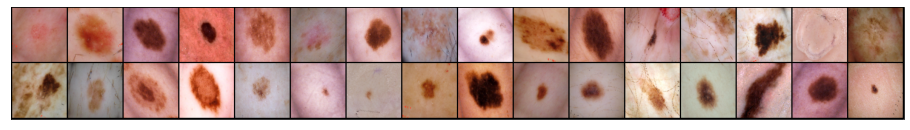

In [238]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(train_dl)

## U-Net Architecture Implementation

In [239]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## Training and Evaluation

In [240]:
# code from my CSC311 Lab

def train(model,
          train_data: DataLoader,
          batch_size=32,
          learning_rate=0.001,
          weight_decay=0.0,
          epochs=10):

    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # Instantiate a few Python lists to track the learning curve
    losses = []
    accuracies = []

    for epoch in range(epochs):

        with tqdm(total=len(train_data), desc="Epoch " + str(epoch+1)) as pbar:
            model.train()
            for i, data in enumerate(train_data, 0):
                # Update the progress bar
                pbar.update()
                # Load the current data
                imgs = data[0].to(DEVICE)
                labels = data[1].to(DEVICE)

                out = model.forward(imgs) # Forward pass. Also can call model(imgs)
                labels = labels.float().unsqueeze(1).to(device=DEVICE)
                loss = criterion(out, labels) # Compute the loss
                loss.backward() # Compute the gradients (like in lab 5)
                optimizer.step() # Like the update() method in lab 5
                optimizer.zero_grad() # Like the cleaup() method in lab 5

                # Save the current training information
                losses.append(loss)
        
        with tqdm(total=len(train_data), desc="Testing Epoch " + str(epoch+1)) as pbar:
            model.eval()
            for i, data in enumerate(train_data, 0):
                # Update the progress bar
                pbar.update()
                # Load the current data
                imgs = data[0].to(DEVICE)
                labels = data[1].to(DEVICE)
                labels_int = labels.type(torch.int64).to(DEVICE)
                with torch.no_grad():
                    prediction = torch.sigmoid(model.forward(imgs))
                    prediction = (prediction > 0.5).float()
                    
                    metric = JaccardIndex(num_classes=2).to(DEVICE)
                    accuracy = metric(prediction, labels_int)
                  
                    # Save the current training information
                    accuracies.append(accuracy)

    return losses, accuracies

### Train the model
- learning_rate = 0.001
- weight_decay = 0 (NO weight_decay)
- batch_size = 32
- epochs = 10
- num_iter = Epochs * Batch = 320

In [241]:
model = UNET().to(DEVICE)
loss, accuracy = train(model, train_dl, batch_size=batch_size, learning_rate=0.001, weight_decay=0.0, epochs=10)

Testing Epoch 10: 100%|██████████| 4/4 [00:19<00:00,  4.80s/it]


## Plot

In [243]:
# A function that plots the loss of a training
# It will average out each epoch
def plot_loss(loss, num_epochs, name):
    loss = torch.tensor(loss, device="cpu")
    loss_per_epoch = []
    curr_sum = 0
    num_batch = len(loss)//num_epochs
    for i in range(len(loss)):
        if i % num_batch == num_batch-1:
            curr_sum += loss[i]
            loss_per_epoch.append(curr_sum/num_batch)
            curr_sum = 0
        else:
            curr_sum += loss[i]

    # Plot the graph
    plt.plot(range(num_epochs), loss_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.savefig(name)
    plt.show()

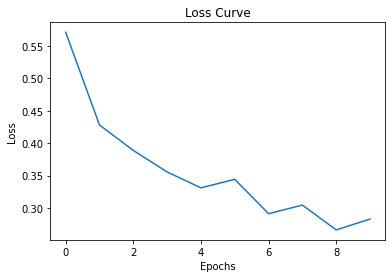

In [244]:
plot_loss(loss, 10, "UNet_10")

In [255]:
# A function that plots the loss of a training
# It will average out each epoch
def plot_accuracy(accuracy, num_epochs, name):
    accuracy = torch.tensor(accuracy, device="cpu")
    accuracy_per_epoch = []
    curr_sum = 0
    num_batch = len(accuracy)//num_epochs
    for i in range(len(accuracy)):
        if i % num_batch == num_batch-1:
            curr_sum += accuracy[i]
            accuracy_per_epoch.append(curr_sum/num_batch)
            curr_sum = 0
        else:
            curr_sum += accuracy[i]

    # Plot the graph
    plt.plot(range(num_epochs), accuracy_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.savefig(name)
    plt.show()

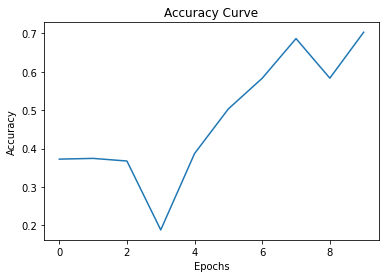

In [256]:
plot_accuracy(accuracy, 10, "UNet_10_accuracy")